# Analiza danych
Na początku przyjrzymy się dostarczonym danym. Wczytujemy je z pobranych plików.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
LOC = 'data'

class_mapping = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
np.random.seed(2024)

def load_data(prefix):
    return np.load(f'{prefix}/X_train.npy'), np.load(f'{prefix}/y_train.npy'), np.load(f'{prefix}/X_val.npy'), np.load(f'{prefix}/y_val.npy'), np.load(f'{prefix}/X_test.npy')

X_train, y_train, X_val, y_val, X_test = load_data(LOC)

Badamy kształt zbiorów.

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(151166, 28, 28)
(151166, 26)
(37792, 28, 28)
(37792, 26)
(31346, 28, 28)


Widzimy zbiory danych (treningowy, walidacyjny i testowy), obrazków 28x28 oraz etykiety zakodowane OneHotem o długości 26, co odpowiada liczbie klas.
Teraz przyjrzyjmy się występowaniu reprezentantów poszczególnych klas w zbiorach danych, zgłebiając zapowiedziany problem nierównowagi klas.

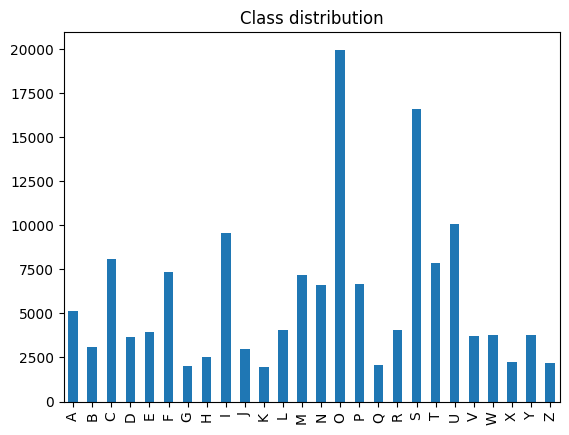

In [6]:
occurences_train = pd.Series(np.ndarray.argmax(y_train, axis=1)).value_counts().sort_index().rename(lambda x: class_mapping[x])
occurences_train.plot.bar()
plt.title("Class distribution")
plt.show()

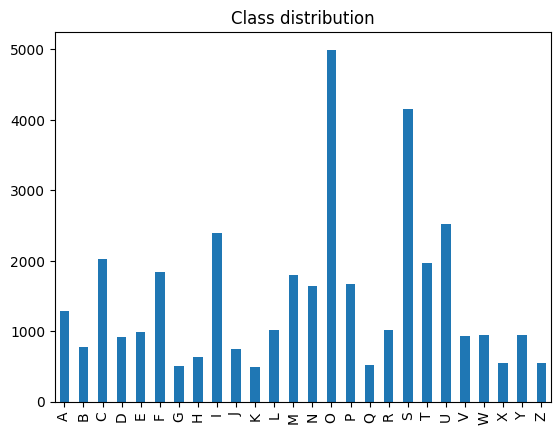

In [7]:
occurences_val = pd.Series(np.ndarray.argmax(y_val, axis=1)).value_counts().sort_index().rename(lambda x: class_mapping[x])
occurences_val.plot.bar()
plt.title("Class distribution")
plt.show()

In [8]:
pd.DataFrame([occurences_train,occurences_val]).T.corr()

,count,count
count,1.0,1.0
count,1.0,1.0


Widzimy, że rozkłady są takie same: z przewagą pewnych klas ('O', 'S') i niedowagą innych ('G', 'K', 'Q'). Sytuacja ta może wpłynąć na osiągi naszego modelu, jednakże użycie metryki f1-min skutecznie kompensuje ewentualne niedotrenowanie mniej licznych klas.

Teraz przyjrzyjmy się elementom testowego zbioru danych.

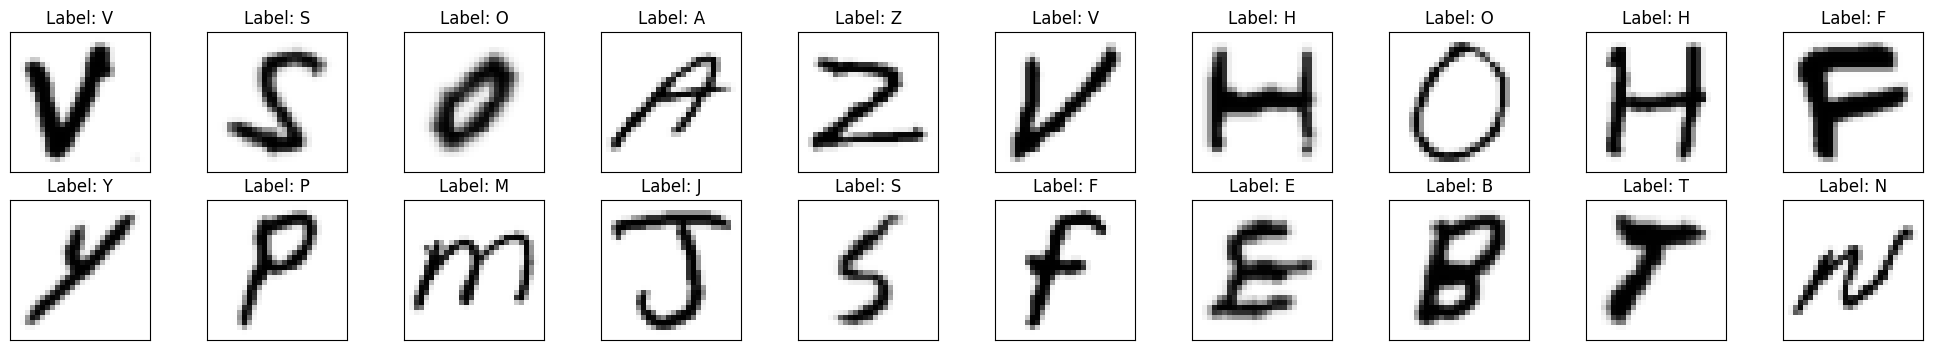

In [9]:
N = 10
choices = np.random.choice(len(X_train), N * 2)
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx, img in enumerate(X_train[choices]):
    ax = fig.add_subplot(2, N, idx + 1, xticks=[], yticks=[])
    plt.imshow(img, cmap='Greys')
    lab = class_mapping[y_train[choices[idx]].argmax()]
    ax.set_title(f'Label: {lab}')

Co dosyć logiczne, ja (człowiek) nie jestem w stanie rozpoznać wszystkich liter poprawnie, bynajmniej nie ze względu na moje ograniczenia obliczeniowe, a kognitywne.

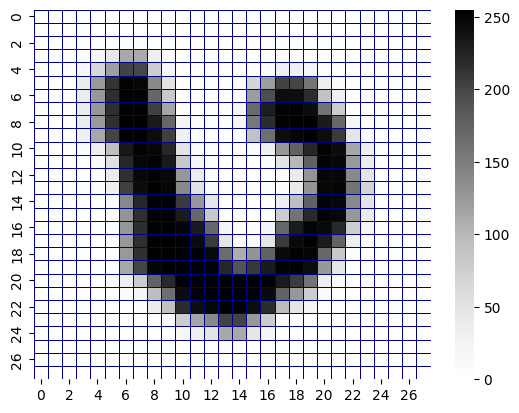

In [10]:
img = X_train[0]
sns.heatmap(img, annot = False, cmap ='Greys', 
            linecolor ='navy', linewidths = 0.5)
plt.show()

Każda litera jest przedstawiona jako macierz 28x28 wartości od 0 do 255.

In [11]:
img = X_train[0][12:26,12:26]
print(img)

[[  5   0   0   0   0   5  39 129 250 250 139  49   0   0]
 [  9   0   0   0   0   5  39 129 250 251 159  69   1   0]
 [ 46   0   0   0   0  34  95 177 252 250 139  49   0   0]
 [ 83   3   0   0   3  79 159 220 253 249 127  38   0   0]
 [171  22   3   3  22 171 232 251 247 220  77  20   0   0]
 [208  47  11  12  48 208 246 253 232 175  34   7   0   0]
 [247 166 109 129 176 247 253 251 171  83   3   0   0   0]
 [253 222 190 210 232 253 253 244 126  46   0   0   0   0]
 [254 254 253 254 253 232 207 159  33   7   0   0   0   0]
 [254 254 254 253 246 175 127  79   8   1   0   0   0   0]
 [250 254 254 244 218  95  47  22   1   0   0   0   0   0]
 [139 202 202 126  79   8   1   0   0   0   0   0   0   0]
 [ 50 112 112  46  22   1   0   0   0   0   0   0   0   0]
 [  0   3   3   0   0   0   0   0   0   0   0   0   0   0]]


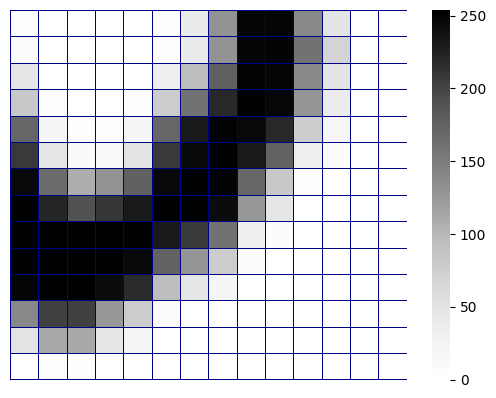

In [12]:
import seaborn as sns

sns.heatmap(img, annot = False, cmap ='Greys', 
            linecolor ='navy', linewidths = 0.5, xticklabels=[], yticklabels=[])
plt.show()

In [13]:
MEAN = X_train.mean()
STD = X_train.std()
print(f'TRAINING SET:\n'
      f'shape : {X_train.shape}\n'
      f'mean : {MEAN}\n'
      f'std : {STD}\n')

TRAINING SET:
shape : (151166, 28, 28)
mean : 45.72014620465892
std : 85.51684674222706


Otrzymujemy wartości średniej i odchylenia zbioru treningowego, które będziemy dalej używać do standaryzacji wejściowych tensorów.

# Przygotowanie danych

Teraz przechodzimy do przygotowania danych tak, aby mogły zostać użyte przez model.

In [14]:
def transform_imgs(X):
    X = torch.tensor(X, dtype=torch.float32, device=DEVICE)
    X = transforms.Normalize(MEAN,STD)(X)
    return X
def transform_labels(y):
    y = torch.tensor(y,device=DEVICE)
    y = y.argmax(dim=1)
    return y

In [15]:
train_imgs = transform_imgs(X_train)
train_labels = transform_labels(y_train)
val_imgs = transform_imgs(X_val)
val_labels = transform_labels(y_val)

Problem niedoreprezentowania pewnych klas rozwiążemy poprzez użycie przy treningu wag o wartościach przeciwnie proporcjonalnych do występowania w całym zbiorze elementów danej klasy. *W toku trenowania modeli koncepcja ta została odrzucona jako niezwiększająca osiągów.*

In [16]:
weights = -torch.Tensor(np.array(np.unique(train_labels, return_counts=True))[1]/len(train_labels))

In [17]:
train_data = TensorDataset(train_imgs, train_labels)
val_data = TensorDataset(val_imgs,val_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [18]:
next(iter(train_loader))

[tensor([[[-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          [-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          [-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          ...,
          [-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          [-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          [-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346]],
 
         [[-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          [-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          [-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          ...,
          [-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          [-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          [-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346]],
 
         [[-0.5346, -0.5346, -0.5346,  ..., -0.5346, -0.5346, -0.5346],
          [-0.5346, -0.5346,

Tak przygotowanymi batchami *nakarmimy* model.